In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from grid_tools import plot_hot, count_total_energy, calculate_boltzmann_probability, phase_separate

%matplotlib inline

### Load sample grid

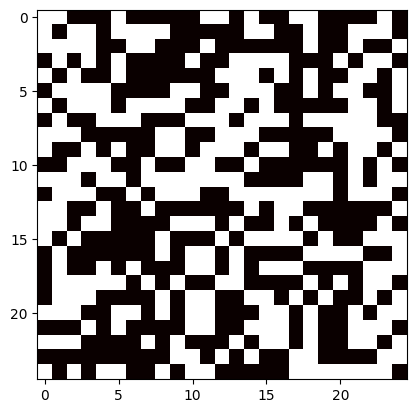

In [2]:
seed = 618
grid = np.load(f'../data/grid_sample/grid_{seed}.npy')
plot_hot(grid)

### Evaluate the total energy of the grid

This grid is very mixed, the energy should be much greater than 0.

In [3]:
total_energy_grid = count_total_energy(grid)

print("\n", "Total Energy:", total_energy_grid, "\n")


 Total Energy: 1288 



### Evaluate change in total energy with respect to number of simulation iterations

Phase separation simulations were performed on the sample grid with varying numbers
of iterations in the simulation. 

The number of iterations considered were $10^n$, where $n=1,2,3,4,5$.

Five simulations are performed for each number of iteration considered. 

The following code will read each simulation data file from `../data/`, identify the final energy after each simulation, and calculate the after over all trials for each number of iterations considered.

In [4]:
# Define an array of logarithmically spaced values from 10^1 to 10^5 with 5 elements
n_iterations = np.logspace(1, 5, 5)

# Create empty lists to store mean and standard deviation of energy for each iteration
iter_energy_mean = []
iter_energy_std = []

# Iterate over the values in n_iterations
for n_iter in n_iterations:
    
    # Create an empty list to store dataframes
    df_list = []

    # Perform the following operations 5 times
    for i in range(5):
    
        # Read the CSV files in ../data
        data_iter = pd.read_csv(f'../data/simulation_data/data_separated_grid_{str(seed)}_iter_test_{int(n_iter)}_run_{i}.csv')
        
        # Append the last row (the final total energy) of the dataframe to df_list
        df_list.append(data_iter.iloc[-1])
        
    # Create a new dataframe from df_list
    df_iter_all = pd.DataFrame(df_list)
    
    # Calculate the mean and standard deviation of the 'total_energy' column in df_iter_all
    iter_energy_mean.append(df_iter_all['total_energy'].mean())
    iter_energy_std.append(df_iter_all['total_energy'].std())


The next code block creates a chart showing the average values of total 
energy for different numbers of iterations (with error bars).

The x-axis label is set to "No. Iterations" and the values are displayed on a logarithmic scale.
The y-axis label is set to "Total Energy".

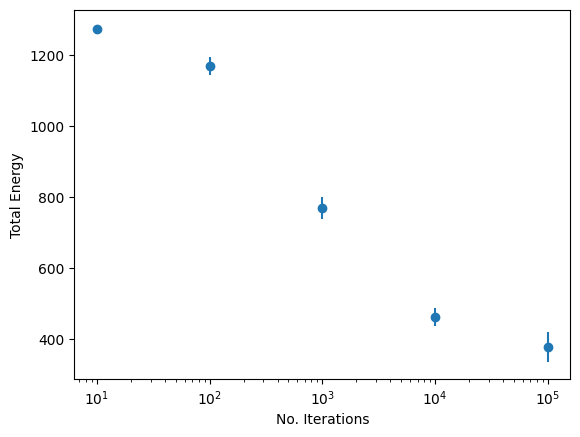

In [5]:
# Create a DataFrame with 'iter_energy_mean' as data and column labels as the logarithm (base 10) of 'n_iterations'
averages_iter = pd.DataFrame(data=[iter_energy_mean], columns=np.log10(n_iterations).astype('int').astype('str'))

# Create a DataFrame with 'iter_energy_std' as data and column labels as the logarithm (base 10) of 'n_iterations'
std_devs_iter = pd.DataFrame(data=[iter_energy_std], columns=np.log10(n_iterations).astype('int').astype('str'))

# Plot an errorbar chart with x-axis values as 'n_iterations', y-axis values as the first row of 'averages_iter',
# and error bars determined by the first row of 'std_devs_iter'.
plt.errorbar(x=n_iterations, y=averages_iter.iloc[0], yerr=std_devs_iter.iloc[0], fmt='o')

# Set the x-axis scale to logarithmic
plt.xscale('log')

plt.xlabel('No. Iterations')
plt.ylabel('Total Energy')

plt.savefig('../results/test_iterations_1_5.png')

### Limit to number of iterations

With increasing numbers of iterations, the decrease in total energy decrease starts to 
approach a limit. For $10^5$ iterations, the resulting grid will look like this:

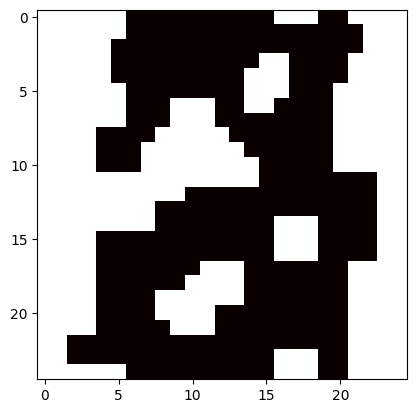

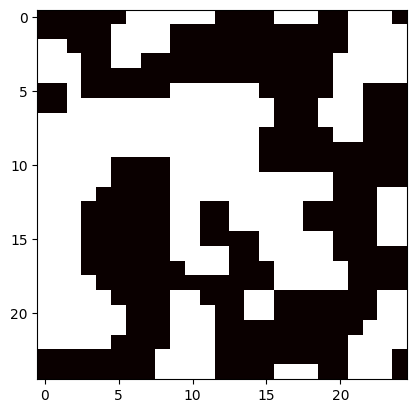

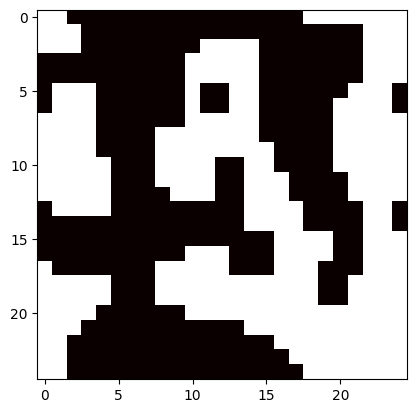

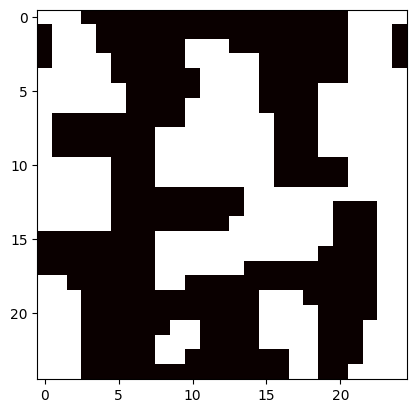

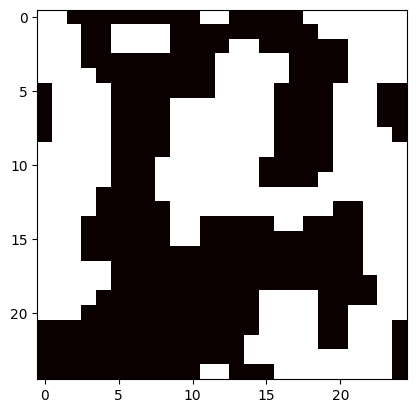

In [6]:
seed = 618

for i in range(5):
    separated_grid_sample = np.load(f'../data/separated_grids/separated_grid_{seed}_iter_test_100000_run_{i}.npy')
    plot_hot(separated_grid_sample)

### Explaining resulting grid patterns

Using the basic simulated annealing algorithm, points on the grid are only swapped if the first point lands in a more favorable spot, one with identical neighbors. When the grid reaches the type of state shown in the examples above, each point has a number of identical neighbors that is favorable enough, so any additional switches will not further separate or decrease the energy of the mixture.  

However, it is possible to further separate the two phases in this mixture, so that each element has the maximum number of identical neighbors. This leads us to a more robust algorithm for simulated annealing. This algorithm incorporates a calculation of a Boltzmann Probability where this probability determines the likelihood of an unfavorable swap happening. When our phase separation reaches the state shown above, the only way further separation can happen is if the system is "shaken up" more, causing unfavorable swaps. To calculate this probability, we will impose a temperature parameter that models this system in an environment where energy fluctuations are more possible.

### Equation for Boltzmann Probability

The following is the equation for the Boltzmann Probability, which incorporates the difference in energy between the two swapping points in the grid, ($\Delta E$) the model temperature, ($T$) and the empirical Boltzmann constant ($k$)

#### $P(\Delta E) = e^{-{\Delta E}/{kT}}$

Next, let's analyzing how Boltzmann Probability looks over a range of temperatures $(0-2000 K)$
for all possible changes in energy between states $(-4,-3,-2,-1,0)$.

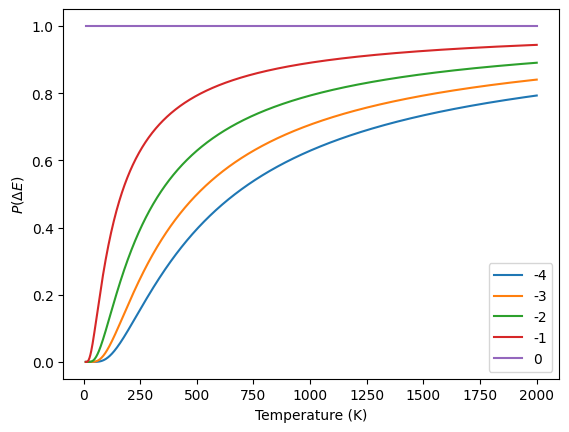

In [7]:
dE = [(0,4), (1,4), (2,4), (3,4), (4,4)] #pairs of energy values that result in all possible energy changes
T = np.linspace(10,2000,1000) #range of temperature values

for e2,e1 in dE:
    #caluclate probability function over temperature range for each energy value pair
    plt.plot(T, calculate_boltzmann_probability(e1,e2,T),label=e2-e1)  
    
plt.xlabel('Temperature (K)')
plt.ylabel('$P(\Delta E)$')
plt.legend()
plt.savefig('../results/boltzmann_probability_10_2000.png')

### Probability as a function of Temperature

For large values of temperature, this probability becomes greater, meaning that the likelihood of an unfavorable swap happening increases. However, if unfavorable swaps happen each time, there will never be separation.

We next test below to identify the ideal temperature region to separate our mixture.

# Temperature Effects

Phase separation simulations were performed on the sample grid with varying values of temperature to include in Boltzmann probability calculation. 

The temperatures considered were $10,20,30,40,50,60,70,80,90,100$ (units of Kelvin).

Five simulations are performed for each number of iteration considered. 

The number of iterations for each simulation was held constant at $10^4$.

In [8]:
# Create an array of 10 values ranging from 100 to 10 representing temperatures
temperatures = np.linspace(100, 10, 10)

# Empty lists to store mean and standard deviation values
temp_energy_mean = []
temp_energy_std = []

# Iterate over each temperature
for temperature in temperatures:
    
    # Empty list to store data frames
    df_list = []

    # Iterate 5 times for each temperature
    for i in range(5):
    
        # Read the CSV files in ../data
        data_temp = pd.read_csv(f'../data/simulation_data/data_separated_grid_{str(seed)}_temp_test_{str(int(temperature)).zfill(3)}_run_{i}.csv')
        
        # Append the last row of the DataFrame to the list
        df_list.append(data_temp.iloc[-1])
        
    # Create a new DataFrame by concatenating all the DataFrames in the list
    df_temp_all = pd.DataFrame(df_list)
    
    # Calculate the mean of the 'total_energy' column and append to the mean list
    temp_energy_mean.append(df_temp_all['total_energy'].mean())
    
    # Calculate the standard deviation of the 'total_energy' column and append to the standard deviation list
    temp_energy_std.append(df_temp_all['total_energy'].std())


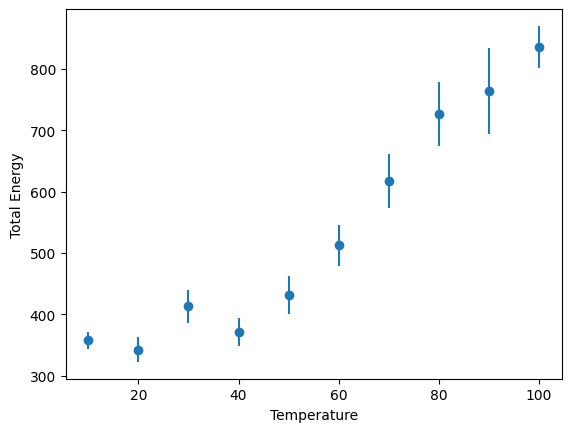

In [9]:
# Create a DataFrame to store the mean values with column names as temperatures converted to strings
averages_temp = pd.DataFrame(data=[temp_energy_mean], columns=temperatures.astype('int').astype('str'))

# Create a DataFrame to store the standard deviation values with column names as temperatures converted to strings
std_devs_temp = pd.DataFrame(data=[temp_energy_std], columns=temperatures.astype('int').astype('str'))

# Plot the error bars with x-values as temperatures, y-values as mean values, and error values as standard deviations
plt.errorbar(x=temperatures, y=averages_temp.iloc[0], yerr=std_devs_temp.iloc[0], fmt='o')

plt.xlabel('Temperature')
plt.ylabel('Total Energy')

# Save the plot as an image file
plt.savefig('../results/test_temperature_10_100.png')


### Total Energy Decrease as a Function of Temperature

From the above plot, temperature values below 50 produce comparable, or lower, total energy values than simulations without temperature effects, with the same number of iterations. Next, let's look at the resulting grid patterns:

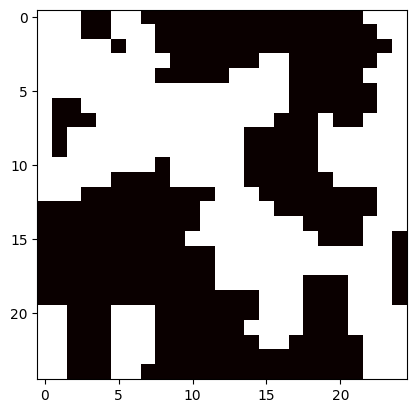

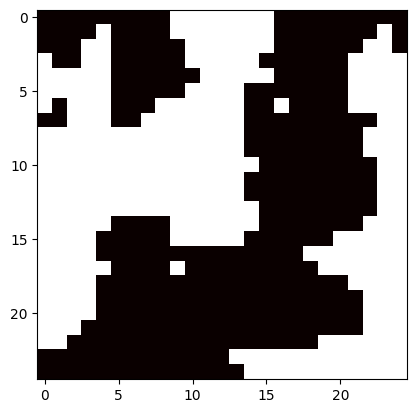

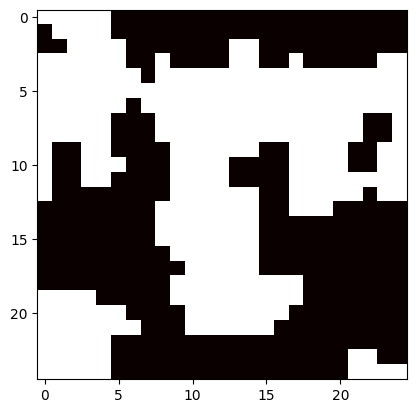

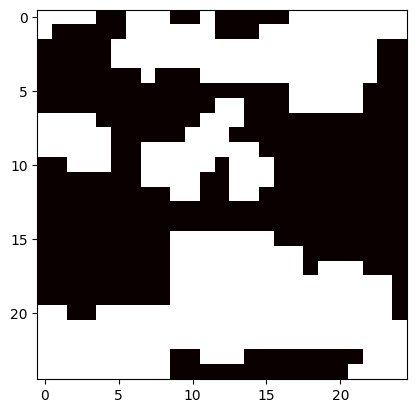

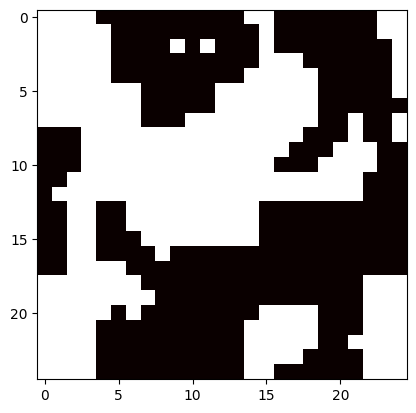

In [10]:
seed = 618

for i in range(5):
    separated_grid_sample = np.load(f'../data/separated_grids/separated_grid_{seed}_temp_test_010_run_{i}.npy')
    plot_hot(separated_grid_sample)

### Similar Grid Patterns

These patterns are comparable to those shown in the previous example. However, the previous example showed grid patterns from simulations that ran for $10^5$ iterations without temperature effects.

For the examples shown directly above, these are the result of simulations with $10^4$ iterations
(an order of magnitude less) that include a temperature of $10 K$.

Let's further investigate how the total energy of the grid decreases at various temperature settings as well as no temperature setting.

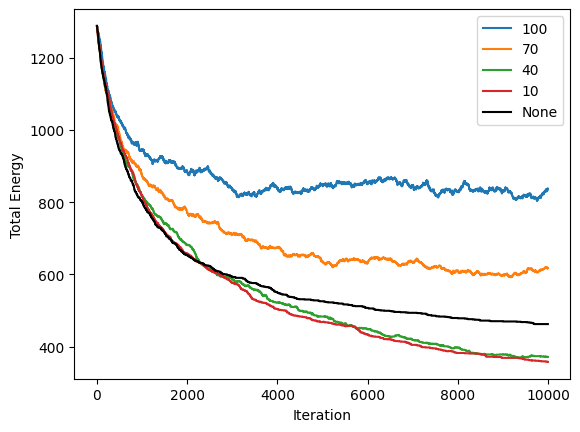

In [12]:
# Define a subset of temperatures
select_temperatures = np.linspace(100, 10, 4)

# Iterate over each selected temperature
for temperature in select_temperatures:

    # Empty list to store data frames
    df_list = []

    # Iterate 5 times for each temperature
    for i in range(5):
    
        # Read the temperature test CSV files in ./production_data
        data_temp = pd.read_csv(f'../data/simulation_data/data_separated_grid_{str(seed)}_temp_test_{str(int(temperature)).zfill(3)}_run_{i}.csv')
        
        # Append the data frame to the list
        df_list.append(data_temp)
    
    # Concatenate all the data frames in the list
    df_iter = pd.concat(df_list)
    
    # Group the data by 'iteration' and calculate the mean of 'total_energy' over all trials,
    # then plot the mean values with a label of the temperature
    df_iter.groupby('iteration').mean()['total_energy'].plot(label=int(temperature))

# Empty list to store data frames
df_list = []

# Iterate 5 times for each trial of iteration test of 10000
for i in range(5):
    
    # Read 10000 iteration CSV files in ./production_data
    data_iter = pd.read_csv(f'../data/simulation_data/data_separated_grid_{str(seed)}_iter_test_10000_run_{i}.csv')
    
    # Append the data frame to the list
    df_list.append(data_iter)
    
# Concatenate all the data frames in the list
df_iter = pd.concat(df_list)

# Group the data by 'iteration' and calculate the mean of 'total_energy' over all trials,
# then plot the mean values with a label of "None" and black color
df_iter.groupby('iteration').mean()['total_energy'].plot(label="None", color='black')

plt.xlabel('Iteration')
plt.ylabel('Total Energy')

plt.legend()
plt.savefig("../results/energy_profiles_comparison.png")

### Energy Profiles Over Simulation Time

The figure above displays the average total energy as a function of simulation time for $10^4$ iterations. Simulations at $100, 70, 40$, and $10 K$ and with no temperature setting are shown. 

At temperatures above 50, the total energy quickly plateaus due to a higher number of swaps happening, regardless if they are favorable. The results in values that are higher than the
simulation without temperature inclusion.

Below 50, the total energy surpasses the temperature excluded simulation around 2500 iterations,
and the final total energy values are lower.

### Producing a near perfect separation

The analysis above shows that phase separation simulations at temperatures below $50 K$ produce greater separation for shorter simulations. However, the resulting grids have not looked like
perfect separations. Since we identified a more optimal region for temperature, we can run a 
phase separation simulation with many more iterations using an appropriate temperature value.

In [22]:
separated_grid = grid.copy()
separated_grid, energy, data_temp = phase_separate(separated_grid,temperature=10,iterations=1000000)

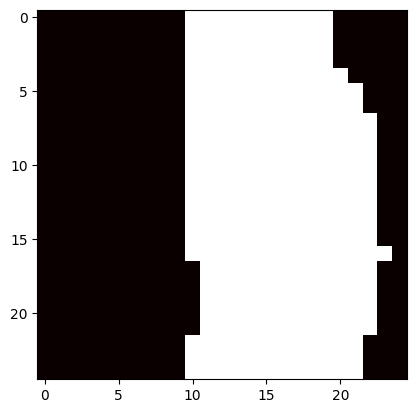

In [23]:
plot_hot(separated_grid)